In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the dataset
df = pd.read_csv("test_Datda.csv")
df = df.dropna(subset=['avg_bat_charge', 'avg_lat', 'avg_long'])  # Drop rows with critical missing values



In [7]:
# Create a copy of the columns with correct names
date_cols = {
    'yearr': 'year',
    'mmm': 'month',
    'ddd': 'day',
    'hr': 'hour'
}
df_date = df[['yearr', 'mmm', 'ddd', 'hr']].rename(columns=date_cols)


In [8]:
df['timestamp'] = pd.to_datetime(df_date)

In [9]:
# Build timestamp
df['half_hour_offset'] = df['half_hour'].map({'h1': 0, 'h2': 30})
df['timestamp'] += pd.to_timedelta(df['half_hour_offset'], unit='m')

# Sort data properly
df = df.sort_values(by=['vin', 'timestamp'])


In [10]:
df

,vin,yearr,mmm,ddd,hr,half_hour,avg_lat,avg_long,avg_bat_charge,timestamp,half_hour_offset
0,MD9EMCDL24F217385,2025,1,1,4,h2,27.312450,77.774628,84.000000,2025-01-01 04:30:00,30
101,MD9EMCDL24F217385,2025,1,1,12,h2,27.237280,77.873283,6.000000,2025-01-01 12:30:00,30
16000,MD9EMCDL24F217385,2025,1,1,14,h1,27.237303,77.873274,6.000000,2025-01-01 14:00:00,0
20933,MD9EMCDL24F217385,2025,1,1,14,h2,27.237280,77.873294,7.750000,2025-01-01 14:30:00,30
3833,MD9EMCDL24F217385,2025,1,1,15,h1,27.237318,77.873311,15.461538,2025-01-01 15:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
149712,MD9EMHDL24K217299,2025,1,4,21,h2,28.613431,77.071906,99.240000,2025-01-04 21:30:00,30
147949,MD9EMHDL24K217299,2025,1,4,22,h1,28.613379,77.071882,98.200000,2025-01-04 22:00:00,0
151638,MD9EMHDL24K217299,2025,1,4,22,h2,28.613346,77.071902,98.000000,2025-01-04 22:30:00,30
149708,MD9EMHDL24K217299,2025,1,4,23,h1,28.613408,77.071908,98.000000,2025-01-04 23:00:00,0


In [11]:
df['bat_diff'] = df.groupby('vin')['avg_bat_charge'].diff()


In [12]:
# Create a shifted diff column to compare with previous timepoint
df['bat_diff_prev'] = df.groupby('vin')['bat_diff'].shift(1)

# Charging start: battery starts increasing after being flat or falling
df['charging_start'] = (df['bat_diff'] > 0) & (df['bat_diff_prev'] <= 0)


In [13]:
df.head(10)

,vin,yearr,mmm,ddd,hr,half_hour,avg_lat,avg_long,avg_bat_charge,timestamp,half_hour_offset,bat_diff,bat_diff_prev,charging_start
0,MD9EMCDL24F217385,2025,1,1,4,h2,27.312450,77.774628,84.000000,2025-01-01 04:30:00,30,NaN,NaN,False
101,MD9EMCDL24F217385,2025,1,1,12,h2,27.237280,77.873283,6.000000,2025-01-01 12:30:00,30,-78.000000,NaN,False
16000,MD9EMCDL24F217385,2025,1,1,14,h1,27.237303,77.873274,6.000000,2025-01-01 14:00:00,0,0.000000,-78.000000,False
20933,MD9EMCDL24F217385,2025,1,1,14,h2,27.237280,77.873294,7.750000,2025-01-01 14:30:00,30,1.750000,0.000000,True
3833,MD9EMCDL24F217385,2025,1,1,15,h1,27.237318,77.873311,15.461538,2025-01-01 15:00:00,0,7.711538,1.750000,False
5945,MD9EMCDL24F217385,2025,1,1,15,h2,27.237309,77.873288,27.160000,2025-01-01 15:30:00,30,11.698462,7.711538,False
1,MD9EMCDL24F217385,2025,1,1,16,h1,27.237260,77.873297,38.200000,2025-01-01 16:00:00,0,11.040000,11.698462,False
100,MD9EMCDL24F217385,2025,1,1,16,h2,27.237237,77.873289,49.800000,2025-01-01 16:30:00,30,11.600000,11.040000,False
1500,MD9EMCDL24F217385,2025,1,1,17,h1,27.237257,77.873284,61.000000,2025-01-01 17:00:00,0,11.200000,11.600000,False
23512,MD9EMCDL24F217385,2025,1,1,17,h2,27.237263,77.873309,70.842105,2025-01-01 17:30:00,30,9.842105,11.200000,False


In [14]:
charging_locs = df[df['charging_start']][['vin', 'timestamp', 'avg_lat', 'avg_long']]


In [15]:
charging_locs

,vin,timestamp,avg_lat,avg_long
20933,MD9EMCDL24F217385,2025-01-01 14:30:00,27.237280,77.873294
17408,MD9EMCDL24F217385,2025-01-02 15:00:00,27.237277,77.873350
75520,MD9EMCDL24F217385,2025-01-03 10:00:00,27.237288,77.873296
69546,MD9EMCDL24F217385,2025-01-03 14:30:00,27.237286,77.873311
111115,MD9EMCDL24F217385,2025-01-04 14:30:00,27.237308,77.873321
...,...,...,...,...
39462,MD9EMHDL24K217299,2025-01-01 22:30:00,28.615997,77.080797
80960,MD9EMHDL24K217299,2025-01-02 17:00:00,28.613210,77.071807
65242,MD9EMHDL24K217299,2025-01-02 18:30:00,28.613464,77.071836
123416,MD9EMHDL24K217299,2025-01-03 17:30:00,28.613413,77.071900


In [16]:
charging_counts = charging_locs.groupby(['vin', 'avg_lat', 'avg_long']).size().reset_index(name='count')
most_common_charging = charging_counts.sort_values('count', ascending=False).drop_duplicates('vin')


In [17]:
charging_locs #All charging locations

,vin,timestamp,avg_lat,avg_long
20933,MD9EMCDL24F217385,2025-01-01 14:30:00,27.237280,77.873294
17408,MD9EMCDL24F217385,2025-01-02 15:00:00,27.237277,77.873350
75520,MD9EMCDL24F217385,2025-01-03 10:00:00,27.237288,77.873296
69546,MD9EMCDL24F217385,2025-01-03 14:30:00,27.237286,77.873311
111115,MD9EMCDL24F217385,2025-01-04 14:30:00,27.237308,77.873321
...,...,...,...,...
39462,MD9EMHDL24K217299,2025-01-01 22:30:00,28.615997,77.080797
80960,MD9EMHDL24K217299,2025-01-02 17:00:00,28.613210,77.071807
65242,MD9EMHDL24K217299,2025-01-02 18:30:00,28.613464,77.071836
123416,MD9EMHDL24K217299,2025-01-03 17:30:00,28.613413,77.071900


In [18]:
most_common_charging  #most common charging locations per vehicle


# Save the results to a CSV file    
# most_common_charging.to_excel('most_common_charging_locations_Q_2.xlsx', index=False)

,vin,avg_lat,avg_long,count
13314,MD9EMHDL24J217234,28.491779,77.293098,25
5191,MD9EMHDL23M217215,1.677722,0.003803,20
10209,MD9EMHDL24E217291,28.708590,77.258362,19
10763,MD9EMHDL24F217113,12.943880,77.620689,15
1564,MD9EMHDL23D217399,1.677722,0.023950,14
...,...,...,...,...
4538,MD9EMHDL23M217059,28.536154,77.451330,1
4516,MD9EMHDL23M217029,17.447305,78.520470,1
4557,MD9EMHDL23M217060,12.520556,76.891560,1
4595,MD9EMHDL23M217078,13.100448,77.596820,1


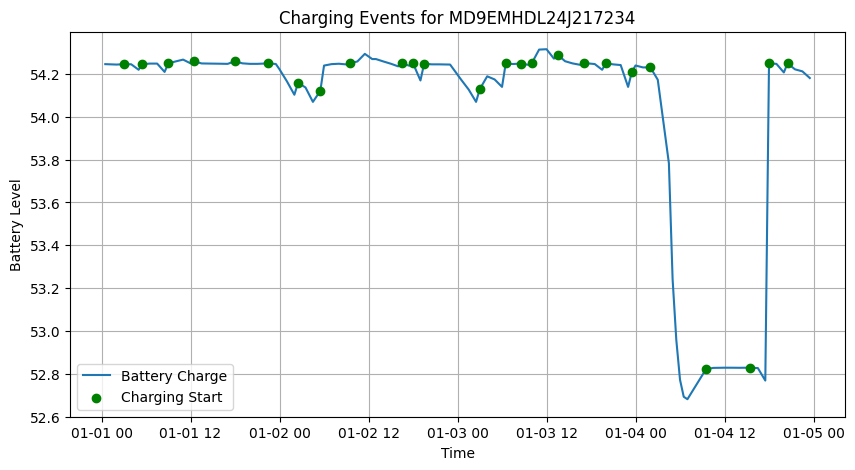

In [23]:
import matplotlib.pyplot as plt

# Example: for one vehicle's battery vs. time
vin = 'MD9EMHDL24J217234'
vehicle_df = df[df['vin'] == vin]

plt.figure(figsize=(10, 5))
plt.plot(vehicle_df['timestamp'], vehicle_df['avg_bat_charge'], label='Battery Charge')
plt.scatter(vehicle_df[vehicle_df['charging_start']]['timestamp'],
            vehicle_df[vehicle_df['charging_start']]['avg_bat_charge'],
            color='green', label='Charging Start', zorder=3)
plt.xlabel("Time")
plt.ylabel("Battery Level")
plt.title(f"Charging Events for {vin}")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
vehicle_df[vehicle_df['charging_start']]['timestamp']

24395    2025-01-01 03:00:00
24391    2025-01-01 05:30:00
36377    2025-01-01 09:00:00
39207    2025-01-01 12:30:00
39209    2025-01-01 18:00:00
16233    2025-01-01 22:30:00
75254    2025-01-02 02:30:00
80676    2025-01-02 05:30:00
69248    2025-01-02 09:30:00
75255    2025-01-02 16:30:00
75252    2025-01-02 18:00:00
75253    2025-01-02 19:30:00
121887   2025-01-03 03:00:00
116582   2025-01-03 06:30:00
121883   2025-01-03 08:30:00
106388   2025-01-03 10:00:00
106391   2025-01-03 13:30:00
106387   2025-01-03 17:00:00
106392   2025-01-03 20:00:00
110818   2025-01-03 23:30:00
151354   2025-01-04 02:00:00
153727   2025-01-04 09:30:00
153728   2025-01-04 15:30:00
149440   2025-01-04 18:00:00
147645   2025-01-04 20:30:00
Name: timestamp, dtype: datetime64[ns]